In [58]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [59]:
# read data from Data+_2025/data/enrollment_projections/sgr_table_region_2324_20240710.xlsx in Google Drive
sgr_data = pd.read_excel(r'/Users/leahwallihan/Durham_school_planning/sgr_htype_region.xlsx')

In [60]:
# remove null values and shorten to only use relevant columns
sgr_data = sgr_data.dropna()
sgr_data.rename(columns={'sgr_dps_2324_all.1': 'sgr_dps_avg_k12'}, inplace=True) # because there might be a typo in the file?
sgr_data = sgr_data[['housing_type','region','sgr_dps_avg_k12']]
sgr_data['sgr_dps_avg_k12'] = sgr_data['sgr_dps_avg_k12'].round(4)
sgr_data.set_index(['region', 'housing_type'], inplace=True)

In [61]:
# read in shapefile to get geometries for HS regions from Data+_2025/QGIS/DPS shapefiles from layers in Google Drive
regions = gpd.read_file(r'/Users/leahwallihan/Durham_school_planning/geospatial files/HS_regions')[['region', 'geometry']]
regions = regions.to_crs('EPSG:4326')
#read in geojson with residential developments
res_dev = gpd.read_file(r'/Users/leahwallihan/Durham_school_planning/DPS-Planning/GIS_files/resdev_cases.geojson')
res_dev = res_dev.to_crs('EPSG:4326')

In [62]:
# function to count number of students in each row
def count_students(row): 
        
    htype_map = {
        'sf_detached': 'sf_detach',
        'sf_attached': 'sf_attach',
        'duplex/triplex': 'du_tri',
        'multifamily': 'mf_apt',
        'condo': 'condo'
    }

    region = row['region']

    total = 0
    for col_name, sgr_col in htype_map.items():
        count = row.get(col_name, 0)

        try:
            multiplier = sgr_data.loc[(region, sgr_col), 'sgr_dps_avg_k12']
        except KeyError:
            multiplier = 0

        total += count * multiplier

    return total

In [63]:
res_dev['student_gen'] = res_dev.apply(count_students, axis=1)

In [64]:
# gets counts for each region
region_gen = res_dev.groupby('region')['student_gen'].sum()
regions.set_index('region', inplace=True)
regions['student_gen'] = region_gen

In [65]:
#regions.to_file('region_gen.geojson', driver='GeoJSON')

In [66]:
#res_dev.to_file('resdev_with_stu_proj.geojson', driver='GeoJSON')

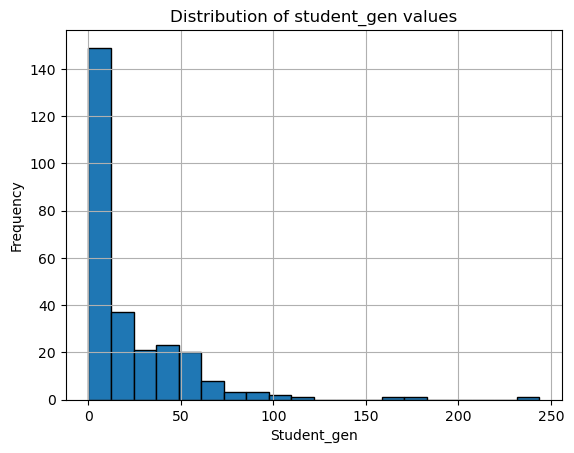

In [67]:
#res_dev["student_gen"].max()

res_dev["student_gen"].plot.hist(bins=20, edgecolor='black')

plt.xlabel("Student_gen")
plt.ylabel("Frequency")
plt.title("Distribution of student_gen values")
plt.grid(True)

plt.show()

In [107]:
# read in planning unit shapefile 
pu = gpd.read_file('/Users/leahwallihan/Durham_school_planning/geospatial files/pu_shape.geojson')[['OBJECTID', 'geometry']]
pu = pu.to_crs('EPSG:4326')

In [109]:
res_dev

,A_NUMBER,A_TYPE,A_DATE,A_STATUS,A_STATUS_D,A_PROJECT_,A_DESCRIPT,A_USER_ID,A_CASE_PLA,StatCode,...,match_results,sf_detached,sf_attached,duplex/triplex,multifamily,condo,region,pu,geometry,student_gen
0,D2000291,PL_MINSP,2020-12-02,APP,2021-09-03,Umstead Grove Conservation Subdivision,"50 Single - family lots, 1 stormwater pond, ad...",JESSICADO,COURTNEYMC,APP,...,"[(50, None, 'single family', 'lots')]",50,0,0,0,0,North,663,POINT (-78.94561 36.07501),13.4350
1,D2200173,PL_MINSP,2022-05-25,APP,2023-02-01,Pineview Glen Town homes - Mass Grading,Mass grading only site plan for residential to...,JUSTINH,KEAGANSA,APP,...,[ ],0,0,0,0,0,East,249,POINT (-78.81051 35.92776),0.0000
2,D1800378,PL_MINSP,2018-11-28,APP,2020-04-14,Elan Innovation District,Mixe of uses including retail and residential....,JOHNRA,TREYFI,APP,...,[ ],0,0,0,0,0,Central,819,POINT (-78.90421 35.99991),0.0000
3,D2100156,PL_MINSP,2021-06-04,APP,2022-02-02,ALTA Rutherford,Multifamily Apartments,KIMRO,TREYFI,APP,...,[ ],0,0,0,0,0,Central,802,POINT (-78.92991 36.01005),0.0000
4,D1900171,PL_MINSP,2019-05-30,APP,2020-04-03,Ellis Road Phase 3,"37 Townhome units, 102 Attached S-F units (cal...",ROBINSH,COLERE,APP,...,"[(37, None, 'townhouse', 'units'), (102, None,...",248,37,0,0,0,East,132,POINT (-78.86167 35.9519),56.7421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,D2500072,PL_MINSP,2025-03-18,UN_RE,2025-03-18,Leigh Valley,Apartment development to include 324 units.,MICHAELMA,TREYFI,UN_RE,...,"[(324, None, 'apartment', 'units')]",0,0,0,324,0,Southwest,814,POINT (-78.99141 35.91899),60.6852
266,D2500088,PL_MINSP,2025-04-01,UN_RE,2025-04-01,Cornwallis Townhomes,Create 33 townhome site.,EARLENETHO,JALISAHA,UN_RE,...,"[(33, None, 'townhouse', None)]",0,33,0,0,0,Southeast,515,POINT (-78.8931 35.93767),1.9404
267,D2500095,PL_MINSP,2025-04-17,UN_RE,2025-04-17,4702 Farrington Rd - Grading Only,Grading only site plan for future residential ...,NKOST,PEYTONBL,UN_RE,...,[ ],0,0,0,0,0,Southwest,649,POINT (-78.99077 35.93368),0.0000
268,D2500103,PL_MINSP,2025-04-25,UN_RE,2025-04-25,Fayetteville Road MultiFamily,Phase one of overall development - single fami...,FRANCISCOM,TREYFI,UN_RE,...,"[(88, None, 'single family', 'units')]",88,0,0,0,0,Southeast,256,POINT (-78.94976 35.87877),18.9200


In [127]:
# fill missing values
res_dev['pu'] = res_dev['pu'].fillna(0).astype(int)

# get counts for each planning unit
pu_gen = res_dev.groupby('pu')['student_gen'].sum()

In [125]:
pu.head(50)

,OBJECTID,geometry,student_gen
0,1,"MULTIPOLYGON (((-78.82256 36.19379, -78.82287 ...",0
1,2,"MULTIPOLYGON (((-78.86225 36.05177, -78.85945 ...",0
2,3,"MULTIPOLYGON (((-78.79371 35.94418, -78.79394 ...",0
3,4,"MULTIPOLYGON (((-78.98659 35.88678, -78.98626 ...",0
4,5,"MULTIPOLYGON (((-78.7536 36.03136, -78.74348 3...",0
5,6,"MULTIPOLYGON (((-78.81683 35.90901, -78.81684 ...",115
6,7,"MULTIPOLYGON (((-78.89573 35.88917, -78.89509 ...",0
7,8,"MULTIPOLYGON (((-78.89205 35.99003, -78.89203 ...",0
8,9,"MULTIPOLYGON (((-78.86251 35.98147, -78.86303 ...",0
9,10,"MULTIPOLYGON (((-78.89244 35.95776, -78.89243 ...",0
